# CS475 Natural Language Model - Programming Assignment 1

## Submission Guide

This homework is built on top of Micrograd by Andrej Karpathy. He has an excellent [tutorial](https://youtu.be/VMj-3S1tku0?si=EpsUsPGzZs5mIBMi) going over the codebase and building it from scratch. You should have no difficulty solving this homework if you understand that tutorial.

**How to submit**
* Fill out <mark>TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
* Submit one file: hw1_{student_ID}.ipynb to KLMS
    e.g.hw1_20243150.ipynb
* **Late submission policy**: After the submission deadline, you will
immediately lose 20% of the score, another 20% after 24 hours later, and so on.
Submission after 72 hours (3 days) will not be counted. However, you can use late days for this assignment, for which you have to send an email to inform the TAs. See course syllabus website Late Policy section.

**Note**
* Make a copy of this .ipynb file. Do not directly edit this file.
* You are required to use numpy, do not use neither pytorch nor tensorflow.
* Check whether your whole cells work well by restarting runtime code and running all before the submission.
* TA will look into the implemented functions, their validity and give corresponding score to each <mark>TODO</mark> problem.
* Ask questions through Slack so that you can share information with other students.
* TA in charge: Yeahoon Kim (yeahoon.kim@kaist.ac.kr)


**In this programming assignment, you will**
* Learn how the backporpagation works.
* Learn how the pytorch module works.

In [1]:
# Import cell
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from graphviz import Digraph
%matplotlib inline

# set seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

## 1. Derivation of a simple function with one input

### 1.1. What is derivation?

Derivation is a mathematical process used to find the rate of change of a function with respect to its input variables. It is an essential tool in calculus and is widely used in various fields of science and engineering.

In programming, we can approximate the derivative of a function by using numerical methods. One common method is called the **"finite difference approximation."**

The finite difference approximation calculates the derivative by estimating the slope of the function at a given point. It does this by taking the difference between the function values at two nearby points and dividing it by the difference in their corresponding input values. This can be expressed as an equation as follows:

$\frac{f(x+h)-f(x)}{h}$

You can check the detail in [here](https://en.wikipedia.org/wiki/Finite_difference)

### 1.2. Simple example of the derivation
The following is the basic example of the derivation

In [2]:
################## TODO: Implement the gradient function ##################
# The gradient function should take a function f and a point x and return the gradient of f at x.
# The gradient should be approximated using finite differences with a small step size h.
# The function f is assumed to be scalar-valued.
def gradient(f, x: float, h=1e-5) -> float:
    return (f(x+h)-f(x))/h
###########################################################################

In [3]:
# Define function f(x)
def f(x: float) -> float:
    return 3 * x**2 - 4 * x + 5

# Find the gradient of f(x) at x = 2
x = 2
df = gradient(f, x)

print(f"Gradient of function f at the point {x}: {df:.3f}")

Gradient of function f at the point 2: 8.000


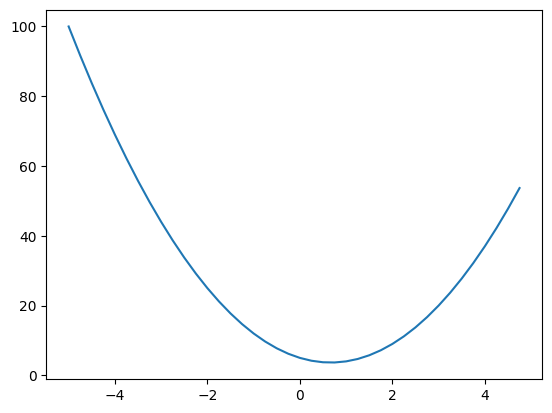

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## 2. Implement backpropagation

### 2.1. Implement value object for the gradient flow
The `Value` object is a class that represents a scalar value and its gradient. It is used in the context of gradient descent and backpropagation algorithms. The `Value` object has the following attributes and methods:

**Attributes:**
- `data`: The scalar value stored in the object.
- `grad`: The gradient of the scalar value with respect to some variable.
- `_backward`: A function that defines the backward pass of the backpropagation algorithm.
- `_prev`: A set of `Value` objects that are the inputs to the operation that produced this object.
- `_op`: A string that represents the operation that produced this object.

**Methods:**
- `__add__(self, other)`: Overloads the `+` operator to perform addition between two `Value` objects or a `Value` object and a scalar.
- `__mul__(self, other)`: Overloads the `*` operator to perform multiplication between two `Value` objects or a `Value` object and a scalar.
- `__pow__(self, other)`: Overloads the `**` operator to perform exponentiation between a `Value` object and an integer or float.
- `relu(self)`: Applies the rectified linear unit (ReLU) activation function to the `Value` object.
- `backward(self)`: Performs the backward pass of the backpropagation algorithm to compute the gradients of the `Value` object and its inputs.

The `Value` object is used in the implementation of neural networks and other machine learning algorithms to compute gradients and update the model parameters during training. It allows for automatic differentiation and efficient computation of gradients using the chain rule.

<mark>TODO</mark> Implement the activation functions.

In [5]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def log(self):
        out = Value(math.log(self.data), (self,), 'log')

        def _backward():
            self.grad += (1/self.data) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    ############# TODO: implement more activation functions ############
    # You can implement more activations such as sigmoid, tanh, silu, gelu, elu etc.
    # Make sure to implement their gradients as well.
    # If there is an activation function you want to implement, implement it here.

    def sigmoid(self):
        # You can refer to the following link to implement the sigmoid function
        # https://en.wikipedia.org/wiki/Sigmoid_function
        out = Value(1 / (1+math.exp(-self.data)), (self,), 'sigmoid')

        def _backward():
            self.grad += out.data * (1-out.data) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        # You can refer to the following link to implement the tanh function
        # https://en.wikipedia.org/wiki/Hyperbolic_function
        out = Value(math.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1-out.data) * (1+out.data) * out.grad
        out._backward = _backward

        return out

    def silu(self):
        # You can refer to the following link to implement the SiLU function
        # https://arxiv.org/abs/1702.03118
        sigmoid = 1 / (1+math.exp(-self.data))
        out = Value(self.data * sigmoid, (self,), 'SiLU')

        def _backward():
            self.grad += (sigmoid + out.data * (1-sigmoid)) * out.grad
        out._backward = _backward

        return out

    def gelu(self):
        # You can refer to the following link to implement the GELU function
        # https://arxiv.org/abs/1606.08415
        x = self.data
        erfv = math.erf(x / (math.sqrt(2)))
        out = Value(x * 0.5 * (1 + erfv), (self,), 'GELU')

        def _backward():
            self.grad += (0.5 * (1 + erfv) + x / math.sqrt(2 * math.pi) * math.exp(-(x**2)/2)) * out.grad
        out._backward = _backward

        return out


    def elu(self, other=1.0):
        # You can refer to the following link to implement the ELU function
        # https://arxiv.org/abs/1511.07289
        x = self.data
        out = Value(x if x>0 else other * (math.exp(x)-1), (self,), 'ELU')

        def _backward():
            self.grad += (1 if x>0 else other * math.exp(x)) * out.grad
        out._backward = _backward

        return out

    ######################################################################

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

Sanity Check for the `sigmoid` and `tanh`

In [6]:
# Function for checking the correctness of the implementation
# You can also try the other activation functions you implemented;
# note that sometimes framework's implementations differ slightly for numererical stability reasons.
# You will be graded correct as long as your answer is reasonable.

def test_sanity_check():
    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.tanh() + z * x
    h = (z * z).sigmoid()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = F.tanh(z) + z * x
    h = F.sigmoid(z * z)
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

test_sanity_check()

# 3. Implement Neural Networks

Now, let's define a Multi-Layer Perceptron (MLP) using the previously defined `Value` object as the basic building block. The MLP will consist of multiple layers, where each layer performs a linear transformation followed by a non-linear activation function.

### 3.1. Explanation of the MLP:
- **Input Layer**: The input layer takes the raw input data and feeds it into the network.
- **Hidden Layers**: Each hidden layer applies a linear transformation (i.e., a weighted sum of inputs) followed by a non-linear activation function (such as ReLU). These layers capture complex patterns in the data by progressively learning higher-level features.
- **Output Layer**: The final layer outputs the predictions.

In this setup, the `Value` objects will be used to perform all the necessary computations while tracking the gradients for backpropagation. This allows the MLP to learn by adjusting its weights based on the gradients computed during the backward pass.

In [7]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

In [8]:
class Neuron(Module):

    def __init__(self, feature_in, acti: str = 'relu'):
        self.w = [Value(random.uniform(-1,1)) for _ in range(feature_in)]
        self.b = Value(0)
        self.acti = acti

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if self.acti is None:
            return act
        elif hasattr(act, self.acti):
            return getattr(act, self.acti)()
        else:
            print("Error: Activation function not defined")
            return None

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.acti} Neuron({len(self.w)})"

In [9]:
class Layer(Module):

    def __init__(self, nin, nout, acti, **kwargs):
        self.neurons = [Neuron(nin, acti, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [10]:
class MLP(Module):

    def __init__(self, nin, nouts, acti='relu'):
        sz = [nin] + nouts
        act = [acti] * (len(nouts)-1) + [None]
        self.layers = [Layer(sz[i], sz[i + 1], acti=act[i]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"



# 4. Neural Networks Example

To ensure that the neural network is functioning correctly, we will evaluate its performance on a dummy dataset: approximating sin(x).

Here we create sine function from -2 to 2 and then try to match the neural network's output with actual sine function's output.

### 4.1. Load Dataset

In [11]:
from sklearn.model_selection import train_test_split

X = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1)
y = np.sin(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example usage
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 1)
X_test shape: (200, 1)
y_train shape: (800, 1)
y_test shape: (200, 1)


### 4.2. Define model

<mark>TODO</mark> Implement the model using MLP. Make it reasonably large (but not too large) to deal with this particular dataset.

In [ ]:
######## TODO: Define the model ########
model = MLP(1, [4, 8, 8, 4, 1])


########################################

### 4.3. Define criterion
For measuring the error between the predicted label and the true labels, you should define the loss function. There are several common loss functions you can use, depending on the type of problem you're solving:
* **L1 Loss (Mean Absolute Error, MAE)**: This loss function calculates the absolute difference between the predicted and true values. It's commonly used in regression tasks where robustness to outliers is important.

  $\text{L1 Loss} = \frac{1}{n} \sum_{i=1}^{n} |\text{prediction}_i - \text{actual}_i|$

You can see the details in [here](https://en.wikipedia.org/wiki/Mean_absolute_error)

* **L2 Loss (Mean Squared Error, MSE)**: This loss function calculates the square of the difference between the predicted and true values. It's widely used in regression tasks because it penalizes larger errors more than smaller ones.

  
  $\text{L2 Loss} = \frac{1}{n} \sum_{i=1}^{n} (\text{prediction}_i - \text{actual}_i)^2$
  
You can see the details in [here](https://en.wikipedia.org/wiki/Mean_squared_error)

In addition, you can try various other loss functions.

### 4.3. Training Step
<mark>TODO</mark> Implement the training step.

In [12]:
def batch_iterator(X, y, batch_size):
  """Yield batches of data."""
  for i in range(0, len(X), batch_size):
      yield X[i:i + batch_size], y[i:i + batch_size]

In [ ]:
######## TODO: ########
gradient_rate = 4e-3  # change as necessary
#######################

num_epochs = 100 # change as necessary; but try to stay within 1000
batch_size = 8 # experiment with this
regul_coef = 1e-4 # change as necessary

# Training loop
for epoch in range(num_epochs):

    for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
        y_pred = [model(data) for data in X_batch]

        ##### TODO: implement L1 and L2 loss. But while training, use only one of them and comment the other  #####
        # implment L1 loss:

        # loss = sum([y_p-y_b if (y_p-y_b).data > 0 else y_b-y_p for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size

        # implement L2 loss:

        loss = sum([(y_p - y_b)**2 for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size

        # TODO: Add L2 regularization to the loss with different regularization coefficients
        # hint: think of model.parameters()
        # note that in reality we do not regularize the bias terms, but for the sake of simplicity you can regularize them as well

        loss += regul_coef * sum([p**2 for p in model.parameters()])

        ################################################

        model.zero_grad()

        loss.backward()

        for p in model.parameters():
            p.data -= gradient_rate * p.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.data}') # feel free to use other ways to track loss (eg different forms of averaging)

Epoch 0, Loss: 0.601146374250052
Epoch 10, Loss: 0.28217656706022687
Epoch 20, Loss: 0.19806197142296983
Epoch 30, Loss: 0.13110984629602265
Epoch 40, Loss: 0.1260131908089266
Epoch 50, Loss: 0.12404050516449208
Epoch 60, Loss: 0.1221202091215264
Epoch 70, Loss: 0.12092451788790522
Epoch 80, Loss: 0.11994668372567013
Epoch 90, Loss: 0.11907493854847281


### 4.3. Evaluation
Evaluate the model performance on holdout data (use L2 loss for all analysis)

In [ ]:
##### TO-DO: Calculate the test loss #######
y_pred = [model(x) for x in X_test]
loss = sum([(y_p - y_t)**2 for y_p, [y_t] in zip(y_pred, y_test)]) / len(y_test)
print(loss)

Value(data=0.06747977921078487, grad=0)


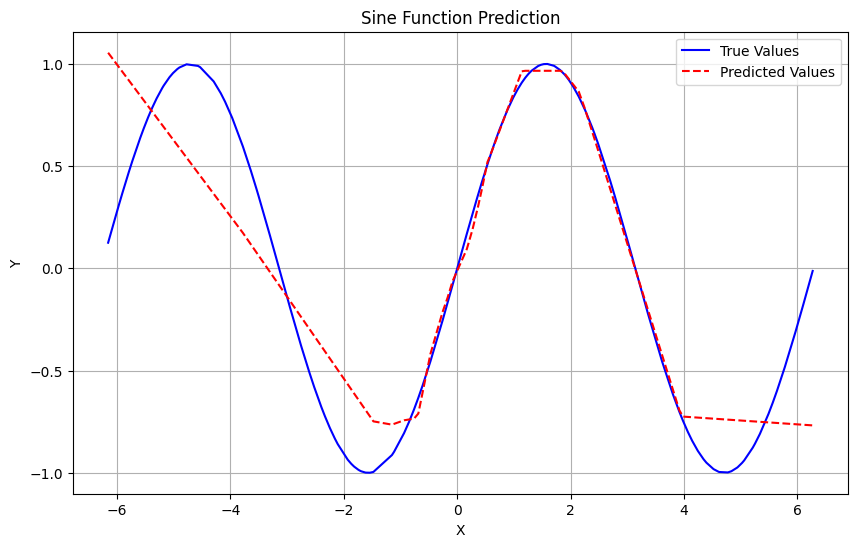

In [ ]:
# Plotting function. Visualize your results
# this code assumes: print(X_test.shape, y_test.shape, y_pred.shape) --> (200, 1) (200, 1) (200,)

sorted_indices = np.argsort(X_test[:, 0]) # sorting is neeed because we randomized the data before
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = np.array([y.data for y in y_pred])[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted, y_test_sorted, label='True Values', color='blue')
plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
plt.title('Sine Function Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

<mark>TODO</mark> Answer the following questions. Plot necessary graphs if needed.

* Which loss function gives the better validation loss? Keep the number of epoch and learning rate same.   
Model trained with L1 loss gives the better validation loss. For the experiment, I made two equally structured models. And I used the same hyperparameters to train them on the equal conditions respectively. After the whole training, model trained with L1 loss gives 0.05293 of validation loss, and 0.08674 for the model trained with L2 loss.
* For the best loss function you find, which non-linearity performs the best?   
GeLU performs the smallest validation loss(0.0055) in experiment. Molel with GeLU converged fastest toward the minimum.
* Does your best working solution overfit? How to prevent overfitting? Does regularization above prevent overfitting?   
I think my model doesn't overfit because its test loss is lower than train loss. I should train with bigger epochs to make it overfitted to the train data. Also, I think the regularization helps to prevent overffiting. When I compare models with and without the regularization, model without regularization gives much smaller validation loss even if I trained both of them with exact same hyperparameters.
* How would you implement regularization without regularizing bias terms? Describe briefly in a paragraph. Be specific on what you will modify.   
When we call a model.parameters(), we have to know which values are weight and which are bias. For that, instead of returning a list of values, we should return a list of tuples that contain a value and a string that indicates like 'w' or 'b'. In the parameters function at Neuron class, we can easily change the way to make a list of parameters like above. And at the training, we can filter out the bias from the parameters.

Comparing loss functions

In [ ]:
# Training loop

gradient_rate = 1e-3
num_epochs = 100
models = [MLP(1, [4, 8, 8, 4, 1]), MLP(1, [4, 8, 8, 4, 1])]

l1_loss = lambda y_pred, y_batch : sum([y_p-y_b if (y_p-y_b).data > 0 else y_b-y_p for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size
l2_loss = lambda y_pred, y_batch : sum([(y_p - y_b)**2 for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size

for epoch in range(num_epochs):
    if epoch % 10 == 0:
            print(f'Epoch {epoch}')

    for i, (model, loss_fn) in enumerate(zip(models, (l1_loss, l2_loss))):
        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            y_pred = [model(data) for data in X_batch]

            loss = loss_fn(y_pred, y_batch)
            loss += regul_coef * sum([p**2 for p in model.parameters()])
            model.zero_grad()

            loss.backward()

            for p in model.parameters():
                p.data -= gradient_rate * p.grad

        if epoch % 10 == 0:
            if i==0:
                print(f"L1 loss model: {loss.data}")
            else:
                print(f"L2 loss model: {loss.data}\n")

Epoch 0
L1 loss model: 0.5953669144517599
L2 loss model: 0.44128484940705753

Epoch 10
L1 loss model: 0.49305676535327475
L2 loss model: 0.24104988568614086

Epoch 20
L1 loss model: 0.4185861981821607
L2 loss model: 0.14516029008355427

Epoch 30
L1 loss model: 0.33959640296603394
L2 loss model: 0.10286397013741785

Epoch 40
L1 loss model: 0.2950061057625196
L2 loss model: 0.08701726479014799

Epoch 50
L1 loss model: 0.26528738595778345
L2 loss model: 0.0799706783954592

Epoch 60
L1 loss model: 0.23052398412232777
L2 loss model: 0.07627200953951335

Epoch 70
L1 loss model: 0.21838595541492314
L2 loss model: 0.07432598641123063

Epoch 80
L1 loss model: 0.21552060301802917
L2 loss model: 0.07318666651918794

Epoch 90
L1 loss model: 0.21738069568554919
L2 loss model: 0.07198037990125118



In [ ]:
compare_loss_fn = []
for i, model in enumerate(models):
    y_pred = [model(x) for x in X_test]
    loss = sum([(y_p - y_t)**2 for y_p, [y_t] in zip(y_pred, y_test)]) / len(y_test)
    compare_loss_fn.append((model, y_pred, loss))
    print(f'Model trained by L{i+1} loss: {loss.data}')

Model trained by L1 loss: 0.052937523615419514
Model trained by L2 loss: 0.08674151221271018


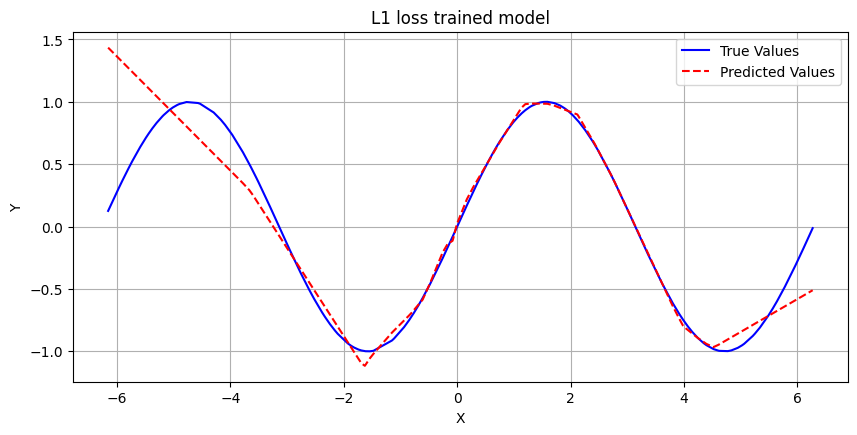

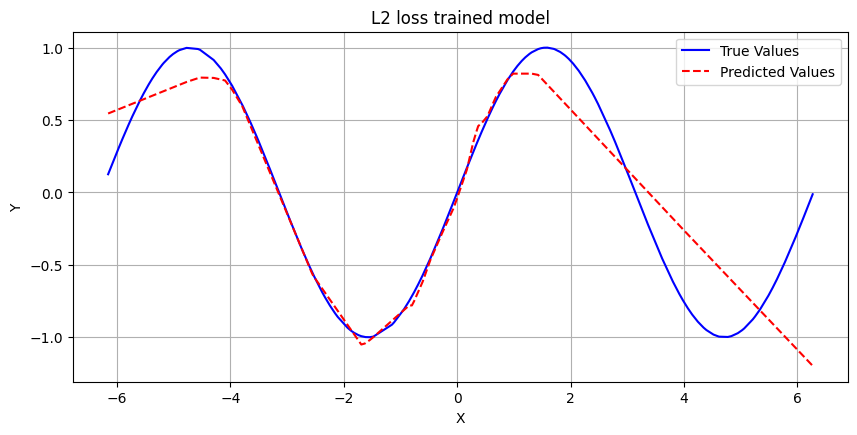

In [ ]:
# Plotting function. Visualize your results
# this code assumes: print(X_test.shape, y_test.shape, y_pred.shape) --> (200, 1) (200, 1) (200,)

for i, (model, y_pred, loss) in enumerate(compare_loss_fn):
    sorted_indices = np.argsort(X_test[:, 0]) # sorting is neeed because we randomized the data before
    X_test_sorted = X_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = np.array([y.data for y in y_pred])[sorted_indices]

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, i+1)
    plt.plot(X_test_sorted, y_test_sorted, label='True Values', color='blue')
    plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'L{i+1} loss trained model')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
plt.show()

Comparision for the activation functions.

In [ ]:
acti_fns = ['relu', 'sigmoid', 'tanh', 'silu', 'gelu', 'elu']
models = [MLP(1, [4, 8, 8, 4, 1], acti=acti_fn) for acti_fn in acti_fns]

In [ ]:
# Training loop

gradient_rate = 5e-3
num_epochs = 50

for epoch in range(num_epochs):
    if epoch % 10 == 0:
            print(f'\nEpoch {epoch}')

    for i, (model, acti_fn) in enumerate(zip(models, acti_fns)):
        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            y_pred = [model(data) for data in X_batch]

            loss = sum([y_p-y_b if (y_p-y_b).data > 0 else y_b-y_p for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size
            loss += regul_coef * sum([p**2 for p in model.parameters()])

            model.zero_grad()
            loss.backward()

            for p in model.parameters():
                p.data -= gradient_rate * p.grad

        if epoch % 10 == 0:
            print(f'{acti_fn} model loss:\t{loss.data}')


Epoch 0
relu model loss:	0.6762224864519911
sigmoid model loss:	0.6871474380430352
tanh model loss:	0.27790200720245645
silu model loss:	0.5805483345269334
gelu model loss:	0.5527572612138014
elu model loss:	0.6753250272232936

Epoch 10
relu model loss:	0.38335104188937874
sigmoid model loss:	0.6881454279793553
tanh model loss:	0.18103580355616827
silu model loss:	0.14521815898985038
gelu model loss:	0.4079183340637547
elu model loss:	0.22989973764011087

Epoch 20
relu model loss:	0.1830985275955065
sigmoid model loss:	0.6860975811609327
tanh model loss:	0.15786881495793292
silu model loss:	0.09427825098426029
gelu model loss:	0.19636075369706613
elu model loss:	0.20658657182941362

Epoch 30
relu model loss:	0.12930143797985455
sigmoid model loss:	0.6847493009909394
tanh model loss:	0.14490007753807527
silu model loss:	0.07844851739968002
gelu model loss:	0.12643463474494834
elu model loss:	0.19957115320032318

Epoch 40
relu model loss:	0.1402308676880685
sigmoid model loss:	0.6808145

In [ ]:
compare_actis = []
for model, acti in zip(models, acti_fns):
    y_pred = [model(x) for x in X_test]
    loss = sum([(y_p - y_t)**2 for y_p, [y_t] in zip(y_pred, y_test)]) / len(y_test)
    compare_actis.append((model, y_pred, loss, acti))
    print(f'{acti} model loss: {loss.data}')

relu model loss: 0.14640331745779717
sigmoid model loss: 0.48713406137011794
tanh model loss: 0.02083013730615806
silu model loss: 0.009678544203106437
gelu model loss: 0.005507244565417825
elu model loss: 0.03479091700968802


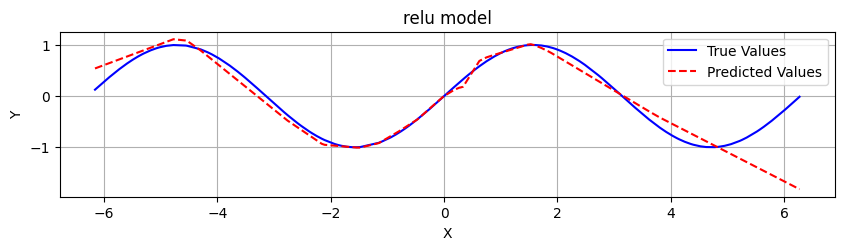

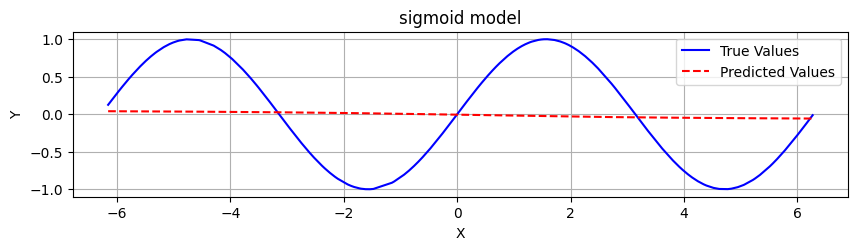

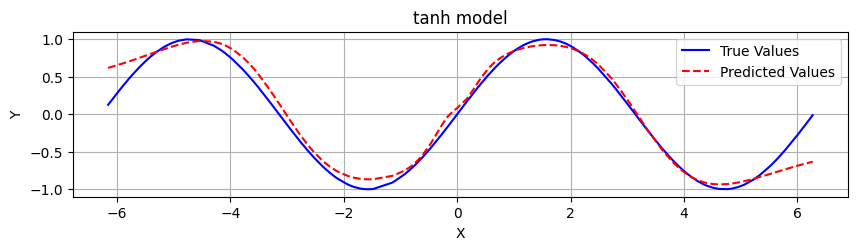

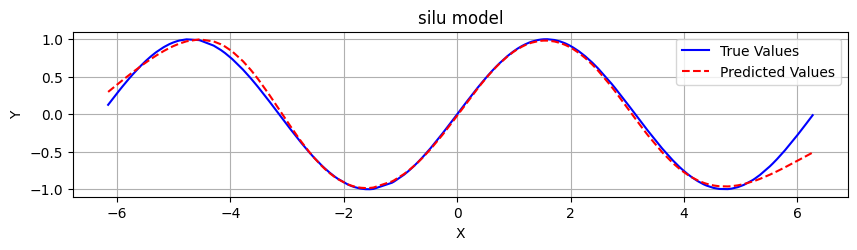

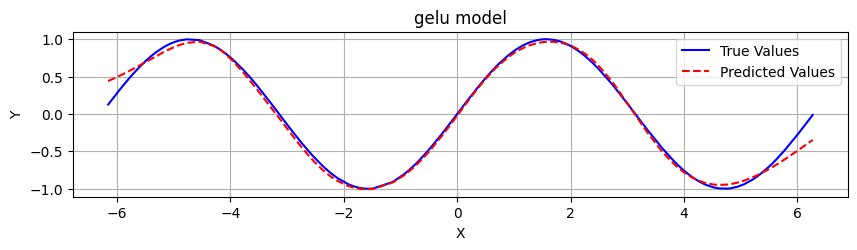

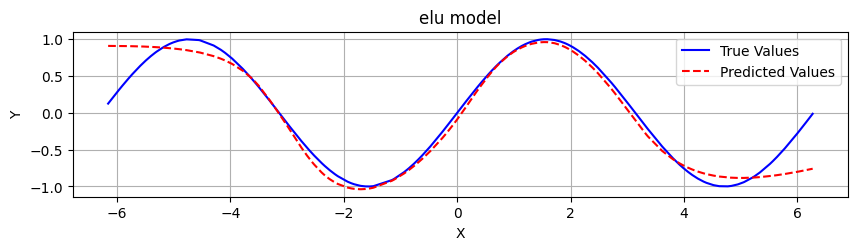

In [ ]:
# Plotting function. Visualize your results
# this code assumes: print(X_test.shape, y_test.shape, y_pred.shape) --> (200, 1) (200, 1) (200,)

for i, (model, y_pred, loss, acti) in enumerate(compare_actis):
    sorted_indices = np.argsort(X_test[:, 0]) # sorting is neeed because we randomized the data before
    X_test_sorted = X_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = np.array([y.data for y in y_pred])[sorted_indices]

    # Plotting
    plt.figure(figsize=(10, 15))
    plt.subplot(6, 1, i+1)
    plt.plot(X_test_sorted, y_test_sorted, label='True Values', color='blue')
    plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{acti} model')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
plt.show()

Comparing the models with and without regularization.

In [13]:
models = [MLP(1, [4, 8, 8, 4, 1], acti='gelu') for _ in range(2)]

In [14]:
# Training loop

gradient_rate = 4e-3
num_epochs = 100
batch_size=8
regul_coef = 1e-4

for epoch in range(num_epochs):
    if epoch % 10 == 0:
            print(f'\nEpoch {epoch}')

    for i, model in enumerate(models):
        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            y_pred = [model(data) for data in X_batch]

            loss = sum([y_p-y_b if (y_p-y_b).data > 0 else y_b-y_p for y_p, [y_b] in zip(y_pred, y_batch)]) / batch_size
            if i:
                loss += regul_coef * sum([p**2 for p in model.parameters()])

            model.zero_grad()
            loss.backward()

            for p in model.parameters():
                p.data -= gradient_rate * p.grad

        if epoch % 10 == 0:
            print(f"model {'with' if i else 'without'} regularization: {loss.data}")


Epoch 0
model without regularization: 0.4552519463899448
model with regularization: 0.42032819451453474

Epoch 10
model without regularization: 0.3613750224612755
model with regularization: 0.23591131287449538

Epoch 20
model without regularization: 0.20416732784007358
model with regularization: 0.15973198256118043

Epoch 30
model without regularization: 0.18313608331137923
model with regularization: 0.1459062259003539

Epoch 40
model without regularization: 0.16190710285854698
model with regularization: 0.12947680554467433

Epoch 50
model without regularization: 0.1498986131593966
model with regularization: 0.11601254849526171

Epoch 60
model without regularization: 0.13600639945319282
model with regularization: 0.11043882690368749

Epoch 70
model without regularization: 0.11457339629815343
model with regularization: 0.12450708085330366

Epoch 80
model without regularization: 0.09666233091016356
model with regularization: 0.14073484938451641

Epoch 90
model without regularization: 0.

In [15]:
compare_regs = []
for i, model in enumerate(models):
    y_pred = [model(x) for x in X_test]
    loss = sum([(y_p - y_t)**2 for y_p, [y_t] in zip(y_pred, y_test)]) / len(y_test)
    compare_regs.append((model, y_pred, loss, i))
    print(f"model {'with' if i else 'without'} regularization: {loss.data}")

model without regularization: 0.005462567616519267
model with regularization: 0.015310745499083747


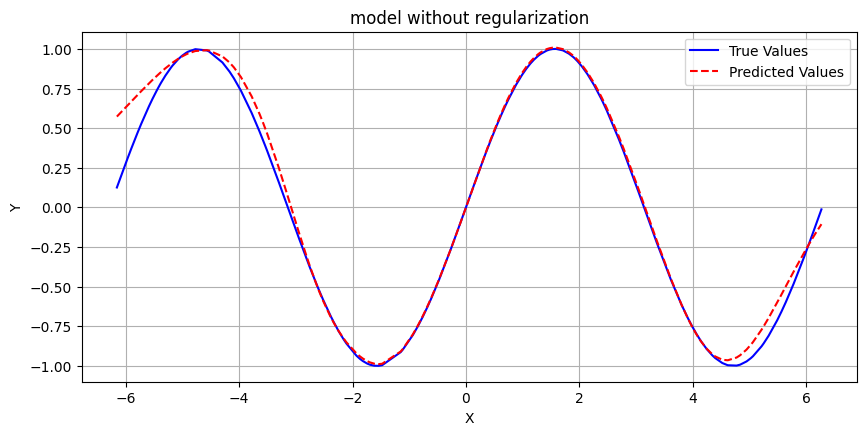

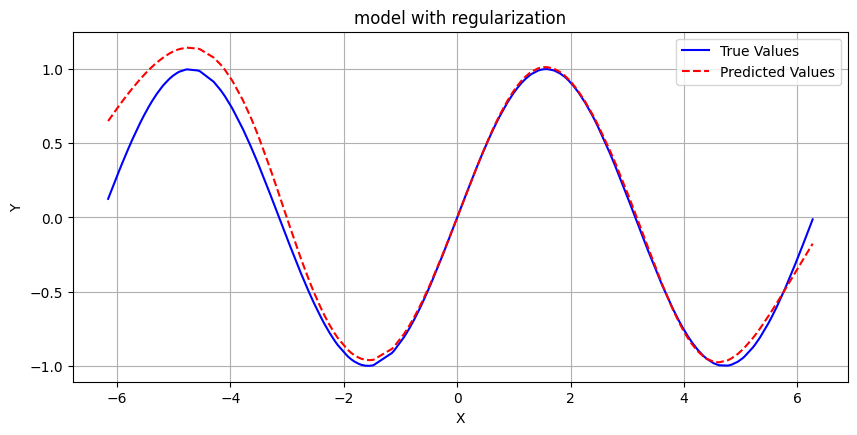

In [16]:
# Plotting function. Visualize your results
# this code assumes: print(X_test.shape, y_test.shape, y_pred.shape) --> (200, 1) (200, 1) (200,)

for model, y_pred, loss, i in compare_regs:
    sorted_indices = np.argsort(X_test[:, 0]) # sorting is neeed because we randomized the data before
    X_test_sorted = X_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = np.array([y.data for y in y_pred])[sorted_indices]

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, i+1)
    plt.plot(X_test_sorted, y_test_sorted, label='True Values', color='blue')
    plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
    plt.title(f"model {'with' if i else 'without'} regularization")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
plt.show()

In [18]:
for i, (X, y) in enumerate(zip([X_train, X_test], [y_train, y_test])):
    y_pred = [model(x) for x in X]
    loss = sum([(y_p - y)**2 for y_p, [y] in zip(y_pred, y)]) / len(y)
    print(f"{'test' if i else 'train'} loss: {loss.data}")

train loss: 0.019804754951567968
test loss: 0.015310745499083747
